# Deep Learning with Lasagne: The Force Awakens 
![alt text](../images/boardgame.jpg)

### How the input looks?
![alt text](../images/dataset.png)

In [1]:
import os
import pandas as pd
import cv2

star_wars_fn = './star_wars_data.csv'

In [2]:
def images_to_file(path_to_photos):
    """ """
    ids = [os.path.splitext(image_id)[0] for image_id in os.listdir(path_to_photos)]
    df_out = pd.DataFrame(columns=['Image', 'Model', 'Model_enc'], index=ids)
    for image_file in os.listdir(path_to_photos):
            image = cv2.imread(os.path.join(path_to_photos, image_file), 0)
            df_out['Image'][os.path.splitext(image_file)[0]] = ' '.join(map(str, image.flatten()))
            df_out['Model'][os.path.splitext(image_file)[0]] = image_file.split('_')[0]
       
    catenc = pd.factorize(df_out['Model'])
    df_out['Model_enc'] = catenc[0]
    print(catenc)
    df_out.to_csv(star_wars_fn)
    return df_out

### How my csv file looks like?

In [3]:
!head ./star_wars_data.csv

,Image,Model,Model_enc
falcon_165,135 94 30 14 3 7 2 7 5 7 6 4 6 5 20 58 58 20 20 18 17 26 22 29 20 6 11 10 14 47 81 140 144 150 163 146 99 115 117 140 141 153 157 93 102 204 139 115 140 150 63 14 20 35 38 32 63 49 53 42 65 67 75 107 159 117 37 68 113 43 102 57 30 37 52 20 12 22 23 34 24 28 29 66 94 56 38 46 53 39 23 53 58 21 63 119 152 81 76 148 161 253 228 172 212 242 228 223 227 213 168 177 164 138 105 125 147 144 144 132 140 130 124 130 127 137 174 196 79 41 36 18 11 5 5 4 6 5 5 7 9 5 15 48 60 22 13 14 18 25 21 25 24 11 11 9 10 36 69 125 143 145 153 150 104 113 113 128 142 145 165 160 109 161 166 133 126 161 79 10 39 36 43 40 43 47 37 47 56 69 114 136 157 88 45 89 137 76 87 111 74 61 34 15 14 18 25 16 24 16 23 69 90 56 36 35 45 39 32 34 49 26 55 139 100 65 79 67 152 255 221 171 225 224 192 167 166 177 162 164 155 121 107 124 157 156 128 128 132 129 132 156 183 202 206 189 28 42 42 17 19 31 1 16 8 5 5 8 11 5 10 36 60 28 9 11 16 18 20 23 25 16 10 11 9 24 58 110 137 136 141 149 104 99

### Let's build our net and prepare the data

In [4]:
import numpy as np
from sklearn.utils import shuffle
import os.path


In [10]:
def load(images_dir="../data/all/"):
    """Load images and target class for Falcon, Lambda and K-wing ships."""
    if os.path.exists(star_wars_fn):
        df = pd.read_csv(star_wars_fn)
    else:
        df = images_to_file(images_dir)
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    y = df['Model_enc'].values
    X, y = shuffle(X, y, random_state=42)
    y = y.astype(np.int32)
    
    return X, y

In [7]:
import warnings; warnings.simplefilter('ignore')
import theano
import lasagne
from lasagne.updates import nesterov_momentum, adam
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
                           MaxPool2DLayer, DenseLayer
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import BatchIterator


### Let's define the layout

In [35]:
def create_net(max_epochs=100):
    return NeuralNet(
        layers=[
                (InputLayer, {'shape': (None, 1, 128, 128)}),
                (Conv2DLayer, {'num_filters': 16, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                # (DropoutLayer, {'p': 0.5}),
                (Conv2DLayer, {'num_filters': 16, 'filter_size': 3, 'W': lasagne.init.GlorotUniform()}),
                (MaxPool2DLayer, {'pool_size': 2}),
                (DenseLayer, {'num_units': 100, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 3, 'nonlinearity': lasagne.nonlinearities.softmax}),
        ],
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,
        regression=False,
        objective_loss_function=categorical_crossentropy,
        #batch_iterator_train=BatchIterator(batch_size=512),
        #on_epoch_finished=[
        #    AdjustVariable('update_learning_rate', start=0.03, stop=0.001),
        #    AdjustVariable('update_momentum', start=0.9, stop=0.9999)  # ,
        #],
        max_epochs=max_epochs,
        verbose=1)

In [9]:
from sklearn.cross_validation import train_test_split
x, y = load()
x = x.reshape(-1, 1, 128, 128)
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=42)
print("La red se entrena con {}".format(X_train.shape)) 

La red se entrena con (2924, 1, 128, 128)


In [36]:
unique, counts = np.unique(y, return_counts=True)
print(counts)

[1230 1477 1471]


In [37]:
net = create_net(20)
net.fit(X_train, y_train)

# Neural Network with 1442883 learnable parameters

## Layer information

  #  name        size
---  ----------  ----------
  0  input0      1x128x128
  1  conv2d1     16x126x126
  2  maxpool2d2  16x63x63
  3  conv2d3     16x61x61
  4  maxpool2d4  16x30x30
  5  dense5      100
  6  dropout6    100
  7  dense7      3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.08508     1.02398    1.05967      0.59316  3.23s
      2     0.98081     0.89967    1.09018      0.67009  3.22s
      3     0.86400     0.81073    1.06570      0.71966  3.22s
      4     0.75925     0.62716    1.21063      0.74359  3.22s
      5     0.68690     0.58407    1.17607      0.76581  3.23s
      6     0.64175     0.49506    1.29632      0.84786  3.22s
      7     0.52341     0.45215    1.15760      0.85470  3.22s
      8     0.52326     0.42146    1.24154      0.84444  3.22s
      9     0.46764     0.35023    1.33522      0.892

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f2b91211438>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f2b91211400>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 128, 128)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'num_filters': 16, 'filter_size': 3, 'W': <lasagne.init.GlorotUniform object at 0x7f2b569bf0f0>}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<cla....layers.dense.DenseLayer'>, {'num_units': 3, 'nonlinearity': <function softmax at 0x7f2b91b82a60>})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f2b90663268>,
     objective_loss_function=<function categorical_crossentropy at 0x7f2b91259ae8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f2b569bfef0>],
     on_training_finished=[],
     on_tr

### Let's check the metrics on this net

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nolearn.lasagne import visualize

In [38]:
print(classification_report(y_test, net.predict(X_test)))

             precision    recall  f1-score   support

          0       0.96      0.95      0.96       330
          1       0.97      0.98      0.97       473
          2       0.97      0.96      0.97       451

avg / total       0.97      0.97      0.97      1254



In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

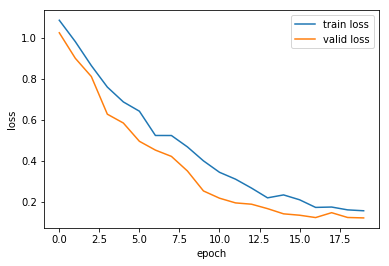

In [39]:
%matplotlib inline
visualize.plot_loss(net)


![alt text](../images/confusion_matrix.png)

In [17]:
def plot_matrix(clf, X_test, y_test):
    """Plot Confussion Matrix from a given classifier"""
   
    plt.clf()
    
    cm = confusion_matrix(y_test, clf.predict(X_test))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    print(cm_normalized)
    plt.tick_params(labelsize=20)

    ax = plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    cb = plt.colorbar()
    cb.ax.tick_params(axis='both', labelsize=20)
    plt.ylabel("True label", fontsize=20)
    plt.xlabel("Predicted label", fontsize=20)
    plt.xticks(range(3),range(3))
    plt.yticks(range(3),range(3))



Normalized confusion matrix
[[ 0.95454545  0.02727273  0.01818182]
 [ 0.00634249  0.98097252  0.01268499]
 [ 0.01995565  0.01552106  0.96452328]]
[[315   9   6]
 [  3 464   6]
 [  9   7 435]]


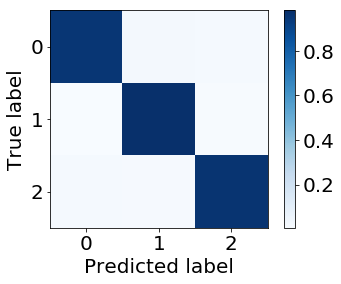

In [40]:
plot_matrix(net, X_test, y_test)
print(confusion_matrix(y_test, net.predict(X_test)))

### You can save your network in a pickle!

![alt text](../images/pickle.jpg)

In [19]:
import pickle

with open('../data/ship_classifier.pickle', 'wb') as f:
        pickle.dump(net, f, -1)


In [20]:
net_loaded = None
with open('../data/ship_classifier.pickle', 'rb') as f:
       net_loaded = pickle.load(f)

In [21]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

net_loaded.verbose = 1
net_loaded.initialize()
layer_info(net_loaded)

# Neural Network with 1442883 learnable parameters

## Layer information

  #  name        size
---  ----------  ----------
  0  input0      1x128x128
  1  conv2d1     16x126x126
  2  maxpool2d2  16x63x63
  3  conv2d3     16x61x61
  4  maxpool2d4  16x30x30
  5  dense5      100
  6  dropout6    100
  7  dense7      3



### What's happening inside?

In [22]:
net.layers

[(lasagne.layers.input.InputLayer, {'shape': (None, 1, 128, 128)}),
 (lasagne.layers.conv.Conv2DLayer,
  {'W': <lasagne.init.GlorotUniform at 0x7f2b9065af28>,
   'filter_size': 3,
   'num_filters': 16}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.conv.Conv2DLayer,
  {'W': <lasagne.init.GlorotUniform at 0x7f2b9065afd0>,
   'filter_size': 3,
   'num_filters': 16}),
 (lasagne.layers.pool.MaxPool2DLayer, {'pool_size': 2}),
 (lasagne.layers.dense.DenseLayer,
  {'nonlinearity': <function lasagne.nonlinearities.rectify>,
   'num_units': 100}),
 (lasagne.layers.noise.DropoutLayer, {'p': 0.5}),
 (lasagne.layers.dense.DenseLayer,
  {'nonlinearity': <function lasagne.nonlinearities.softmax>, 'num_units': 3})]

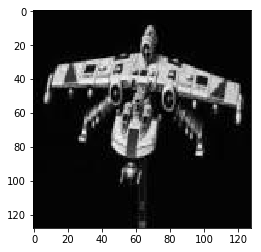

In [23]:
%matplotlib inline

my_image = cv2.imread("../data/kwing.jpg", 0)
plt.imshow(my_image, cmap='gray')
X = np.vstack(my_image) / 255.
plt.imshow(X, cmap='gray')
X = X.astype(np.float32)
X = X.reshape(-1, 1, 128, 128)

In [24]:
net.predict(X)

array([2])

In [25]:
proba = net.predict_proba(X)
proba, proba.sum()

(array([[  3.65777989e-03,   5.34937462e-05,   9.96288776e-01]], dtype=float32),
 1.0)

In [26]:
proba[0, np.argmax(proba)]

0.99628878

<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

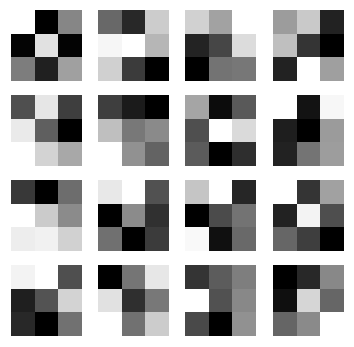

In [27]:
visualize.plot_conv_weights(net.layers_[1])

<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

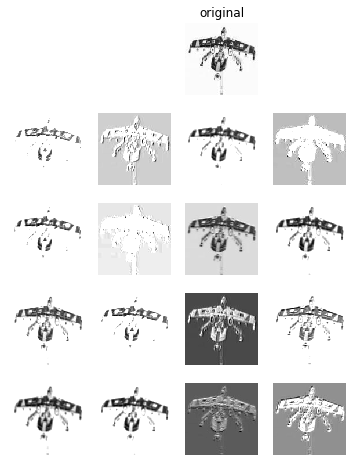

In [41]:
visualize.plot_conv_activity(net.layers_['conv2d1'], X)

### Now we will use are net over video!!

In [29]:
tipos_naves = {0: 'Falcon', 1: 'Lambda', 2: 'K-wing'}

def format_net(my_image):
        X = np.vstack(my_image) / 255.
        X = X.astype(np.float32)
        X = X.reshape(-1, 1, 128, 128)
        
        return X

In [30]:
import time
import cv2

def classifier_over_video(file_name):
    cap = cv2.VideoCapture(file_name)
    frames_count = cap.get(7)
    
    for frame_id in range(int(frames_count)):
        ret, frame = cap.read()
        frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_ = cv2.equalizeHist(frame_)
        res = cv2.resize(frame_, (128, 128), interpolation = cv2.INTER_CUBIC)
        X = format_net(res)
        
        pred = tipos_naves[net.predict(X)[0]]
        proba = net.predict_proba(X)
        proba = str(proba[0, np.argmax(proba)])
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, pred, (10, 500), font, 4, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(frame, proba, (10, 800), font, 4, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
    cap.release()
    cv2.destroyAllWindows()

In [45]:
classifier_over_video("../data/videos_demo/otro_k-wing_nerdearla.mp4")

#### And if you want a more stable video classification ...

In [46]:
import time
import cv2
from collections import Counter

def classifier_over_video_most_common(file_name):
    cap = cv2.VideoCapture(file_name)
    frames_count = cap.get(7)
    clase = []
    
    for frame_id in range(int(frames_count)):
        ret, frame = cap.read()
        frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_ = cv2.equalizeHist(frame_)
        res = cv2.resize(frame_, (128, 128), interpolation = cv2.INTER_CUBIC)
        X = format_net(res)
        clase.append(net.predict(X)[0])
        font = cv2.FONT_HERSHEY_SIMPLEX
        mi_nave_frecuente = Counter(clase).most_common(1)[0][0]
        cv2.putText(frame, tipos_naves[mi_nave_frecuente], (10,500), font, 4,(255,255,255), 2, cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
    cap.release()
    cv2.destroyAllWindows()

In [47]:
classifier_over_video_most_common("../data/videos_demo/otro_k-wing_nerdearla.mp4")